In [1]:
#find spark
import findspark
findspark.init()

#create pyspark context
import pyspark
sc = pyspark.SparkContext(appName="AppName")

#create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import col
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import folium
import branca.colormap
from branca.colormap import linear
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def show_as_df(rdd, length, has_header=False):
    # Read the filtered data into a DataFrame
    df_raw_data = spark.read.csv(rdd, header=has_header)

    # Show the first 10 rows
    df_raw_data.show(length)
    
def show_interval_as_df(rdd, length, startyear, endyear, ignore_first_x=0):
    df_raw_data = spark.read.csv(rdd, header=True)
    data_filtered = df_raw_data
    
    #iterate through columns, ignoring the first x columns (specified by ignore_first_x parameter)
    for i in range(ignore_first_x, len(df_raw_data.columns)):
        column = df_raw_data.columns[i]
        if column != '_c67':
            if int(column) not in range(startyear, endyear+1):
                data_filtered = data_filtered.drop(column)
    data_filtered.show(length)

## load and edit data

**here we load in the initial crop data**

In [4]:
# Read the text file and add an index to each line
crop_data_raw = sc.textFile('data/crop/API_AG.PRD.CREL.MT_DS2_en_csv_v2_5995350.csv')
crop_data_with_index = crop_data_raw.zipWithIndex()

# Filter out the first 4 lines based on the index
filtered_crop_data_with_index = crop_data_with_index.filter(lambda x: x[1] >= 4)

# Extract only the lines without the index
crop_data = filtered_crop_data_with_index.map(lambda x: x[0])

#show_as_df(crop_data_filtered, 10)
show_interval_as_df(crop_data, 3, 1990, 2000, 4)

+--------------------+------------+--------------------+--------------+--------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+----+
|        Country Name|Country Code|      Indicator Name|Indicator Code|    1990|       1991|       1992|       1993|       1994|       1995|       1996|      1997|       1998|       1999|       2000|_c67|
+--------------------+------------+--------------------+--------------+--------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+----+
|               Aruba|         ABW|Cereal production...|AG.PRD.CREL.MT|    NULL|       NULL|       NULL|       NULL|       NULL|       NULL|       NULL|      NULL|       NULL|       NULL|       NULL|NULL|
|Africa Eastern an...|         AFE|Cereal production...|AG.PRD.CREL.MT|39663834|41168615.58|31294451.73|42598525.85|46529657.97|37914124.58|50975166.79|46975957.5|44856484.17|44314

**because of the amount of columns i will first show only a range of years instead of all because otherwise the table is way too big and not very clear**

In [5]:
# read csv as dataframe and create temp table
df_crop_data = spark.read.csv(crop_data, header=True)
df_crop_data.createOrReplaceTempView('crops')

sql = 'SELECT * FROM crops'
spark.sql(sql).show(10)

+--------------------+------------+--------------------+--------------+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+----+----+
|        Country Name|Country Code|      Indicator Name|Indicator Code|1960|    1961|    1962|    1963|    1964|    1965|    1966|    1967|    1968|    1969|    1970|    1971|    1972|    1973|    1974|    1975|    1976|    1977|    1978|    1979|    1980|    1981|    

**here you can see the entire table, and like i said it is not clear at all (you need to zoom out insanely far to have something worthwhile and at that point the letters are so small you can't ever read them)**

**now let's load in the earth surface temperatur dataset**

In [6]:
world_temp_raw = sc.textFile('data/temp/GlobalTemperatures.csv')
spark.read.csv(world_temp_raw, header=True).createOrReplaceTempView('floorTemps')

sql = 'SELECT * FROM floorTemps'
floortemp_df_raw = spark.sql(sql)
floortemp_df_raw.show(10)

+----------+----------------------+---------------------------------+------------------+-----------------------------+------------------+-----------------------------+------------------------------+-----------------------------------------+
|        dt|LandAverageTemperature|LandAverageTemperatureUncertainty|LandMaxTemperature|LandMaxTemperatureUncertainty|LandMinTemperature|LandMinTemperatureUncertainty|LandAndOceanAverageTemperature|LandAndOceanAverageTemperatureUncertainty|
+----------+----------------------+---------------------------------+------------------+-----------------------------+------------------+-----------------------------+------------------------------+-----------------------------------------+
|1750-01-01|    3.0340000000000003|                            3.574|              NULL|                         NULL|              NULL|                         NULL|                          NULL|                                     NULL|
|1750-02-01|                 3.083| 

**as you can see we have quite a big problem: the crop index dataset handles the values per year via its columns, and t he earth surface temp just has a column 'year' and then for each year a seperate row (we will see why this is in a while but fo the sake of showing the data properly i will convert the crop index data to the same format as the earth temp data)**

**another problem is that the crop index data works on a yearly basis, while the earth surface temp works on a day to day basis. Therefore i will start with converting the 'dt' column to show only the year, and then take the average temperature of that year, the absolute lowest temperature that year, and the absolute highest temperature that year.**

In [7]:
#taking average land temp per year
#convert to only year instead of day-to-day basis
temp_only_year = floortemp_df_raw.withColumn('dt', col('dt').substr(1, 4))
temp_only_year.createOrReplaceTempView('date_in_year')
#gemiddelden per jaar
sql = """
SELECT
    dt AS Year,
    AVG(LandAverageTemperature) AS YearlyLandAverageTemperature,
    MAX(LandMaxTemperature) AS YearlyLandMaxTemperature,
    MIN(LandMinTemperature) AS YearlyLandMinTemperature,
    AVG(LandAndOceanAverageTemperature) AS YearlyLandAndOceanAverageTemperature
FROM date_in_year
GROUP BY Year
"""
floortemp_avg_byYear = spark.sql(sql)
floortemp_avg_byYear.show(10)
floortemp_avg_byYear.createOrReplaceTempView('average_temps_by_year')

+----+----------------------------+------------------------+------------------------+------------------------------------+
|Year|YearlyLandAverageTemperature|YearlyLandMaxTemperature|YearlyLandMinTemperature|YearlyLandAndOceanAverageTemperature|
+----+----------------------------+------------------------+------------------------+------------------------------------+
|1750|           8.719363636363639|                    NULL|                    NULL|                                NULL|
|1751|          7.9761428571428565|                    NULL|                    NULL|                                NULL|
|1752|          5.7798333333333325|                    NULL|                    NULL|                                NULL|
|1753|           8.388083333333332|                    NULL|                    NULL|                                NULL|
|1754|           8.469333333333335|                    NULL|                    NULL|                                NULL|
|1755|          

**as you can see, the data goes all the way back to 1750, this isn't really of use to us, as the crop index data only starts at 1960, so we will keep only the years which are present in both datasets**

In [8]:
#only keep the years that are present in both databases
#first surfacetemp
relevant_years_list = ", ".join(map(lambda x: f"'{x}'", df_crop_data.columns))

sql = f"""
SELECT
    *
FROM average_temps_by_year
WHERE (year IN ({relevant_years_list}))
"""

floortemp_relevant_years = spark.sql(sql)
print(floortemp_relevant_years.columns)
floortemp_relevant_years.show(10)
floortemp_relevant_years.createOrReplaceTempView('average_temps_relevant_years')


['Year', 'YearlyLandAverageTemperature', 'YearlyLandMaxTemperature', 'YearlyLandMinTemperature', 'YearlyLandAndOceanAverageTemperature']
+----+----------------------------+------------------------+------------------------+------------------------------------+
|Year|YearlyLandAverageTemperature|YearlyLandMaxTemperature|YearlyLandMinTemperature|YearlyLandAndOceanAverageTemperature|
+----+----------------------------+------------------------+------------------------+------------------------------------+
|1960|                     8.58375|                   9.748|                  -0.978|                  15.291916666666665|
|1961|           8.797666666666666|                   9.299|     -0.2710000000000001|                  15.379916666666668|
|1962|           8.745916666666666|                   9.547|                  -0.416|                  15.325583333333334|
|1963|                       8.856|                    9.95|                  -0.895|                  15.376666666666667|
|1

In [9]:
#now crop data
min_year = int(spark.sql('SELECT MIN(Year) FROM average_temps_by_year').collect()[0][0])
max_year = int(spark.sql('SELECT MAX(Year) FROM average_temps_by_year').collect()[0][0])
print(max_year)

print(df_crop_data.columns)

df_crops_relevant_years = df_crop_data

for i in range(len(df_crop_data.columns)):
    column = df_crop_data.columns[i]
    if column not in ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '_c67']:
        if int(column) not in range(min_year, max_year+1):
            df_crops_relevant_years = df_crops_relevant_years.drop(column)

# Show the modified DataFrame
df_crops_relevant_years.show(10)
df_crops_relevant_years.createOrReplaceTempView('crops_relevant_years')

2015
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '_c67']
+--------------------+------------+--------------------+--------------+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+--------

In [10]:
sql = """
SELECT
    DISTINCT(year)
FROM average_temps_relevant_years
"""

test = spark.sql(sql)
years_list = sorted([row.year for row in test.collect()])
print(years_list)

['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']


**here you can see a nice list of all years that are present in both datasets**

**with this list we can convert the crop index dataset to use a 'year' column and a 'value' column per row, as this is way more readable (but poses another, bigger, problem which i will will adress later)**

In [11]:
date_as_value_sql = """
    SELECT 
        {year} AS Year,
        crop.`Country Name` AS CountryName,
        crop.`Country Code` AS CountryCode,
        crop.`Indicator Name` AS IndicatorName,
        crop.`Indicator Code` AS IndicatorCode,
        crop.`{year}` AS value,
        crop.`_c67`
    FROM crops_relevant_years AS crop
"""

# Concatenate all year queries together
concat_data = " UNION ".join([date_as_value_sql.format(year=year) for year in years_list])
cropdata_per_years = spark.sql(f"SELECT * FROM ({concat_data}) WHERE (value IS NOT NULL)")
cropdata_per_years.createOrReplaceTempView('cropdata_per_years')

In [12]:
spark.sql(f"SELECT * FROM cropdata_per_years").show(10)

+----+--------------------+-----------+--------------------+--------------+---------+----+
|Year|         CountryName|CountryCode|       IndicatorName| IndicatorCode|    value|_c67|
+----+--------------------+-----------+--------------------+--------------+---------+----+
|1961|            Colombia|        COL|Cereal production...|AG.PRD.CREL.MT|  1476921|NULL|
|1961|            IDA only|        IDX|Cereal production...|AG.PRD.CREL.MT| 55289830|NULL|
|1961|Africa Western an...|        AFW|Cereal production...|AG.PRD.CREL.MT| 15199359|NULL|
|1961|             Burundi|        BDI|Cereal production...|AG.PRD.CREL.MT|   130000|NULL|
|1961|             Liberia|        LBR|Cereal production...|AG.PRD.CREL.MT|   115000|NULL|
|1961|              Guyana|        GUY|Cereal production...|AG.PRD.CREL.MT|   216403|NULL|
|1961|          Cabo Verde|        CPV|Cereal production...|AG.PRD.CREL.MT|    13000|NULL|
|1961| East Asia & Pacific|        EAS|Cereal production...|AG.PRD.CREL.MT|200670420|NULL|

**as you can see the data is now way more readable, and is also usable for graphs now**

**for the map we will also need the lowest, average, and highest index value per country throughout the years in order to accurately color the country**

In [13]:
sql = """
    SELECT
        CountryName,
        CountryCode,
        IndicatorName,
        IndicatorCode,
        CAST(MIN(value) AS INT) AS minVal,
        CAST(AVG(value) AS INT) AS avgVal,
        CAST(MAX(value) AS INT) AS maxVal
    FROM cropdata_per_years
    GROUP BY CountryName, CountryCode, IndicatorName, IndicatorCode
"""

country_range_data = spark.sql(sql)
country_range_data.createOrReplaceTempView('country_range_data')
country_range_data.show()

+--------------------+-----------+--------------------+--------------+--------+--------+--------+
|         CountryName|CountryCode|       IndicatorName| IndicatorCode|  minVal|  avgVal|  maxVal|
+--------------------+-----------+--------------------+--------------+--------+--------+--------+
|         Afghanistan|        AFG|Cereal production...|AG.PRD.CREL.MT| 1940000| 3972862| 6748023|
|Africa Eastern an...|        AFE|Cereal production...|AG.PRD.CREL.MT|22746329|43794068|90152806|
|Africa Western an...|        AFW|Cereal production...|AG.PRD.CREL.MT|13757553|32268927|66356180|
|             Albania|        ALB|Cereal production...|AG.PRD.CREL.MT| 1025800|  658654|  997630|
|             Algeria|        DZA|Cereal production...|AG.PRD.CREL.MT| 1038303| 2443225|  964743|
|              Angola|        AGO|Cereal production...|AG.PRD.CREL.MT| 1056844|  610103|  914886|
| Antigua and Barbuda|        ATG|Cereal production...|AG.PRD.CREL.MT|      18|      53|      96|
|          Arab Worl

In [14]:
sql = """
SELECT
    DISTINCT(CountryName)
FROM cropdata_per_years
"""

test = spark.sql(sql)
countries_list = sorted([row.CountryName for row in test.collect()])
print(countries_list)

sql = """
SELECT
    DISTINCT(Year)
FROM cropdata_per_years
"""

test = spark.sql(sql)
years_list = sorted([row.Year for row in test.collect()])
print(years_list)

['Afghanistan', 'Africa Eastern and Southern', 'Africa Western and Central', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean small states', 'Central African Republic', 'Central Europe and the Baltics', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Eritrea', 'Estonia', 'Eswatini', 'Ethio

**we will also need a list of all countries and years we have data of, for use in dropdown widgets**

## Earth surface temperature

**now that we have our data, it's time to make some graphs. for starters let's see the evolution of earth's minimum, maximum, average land, and average overall temperature**

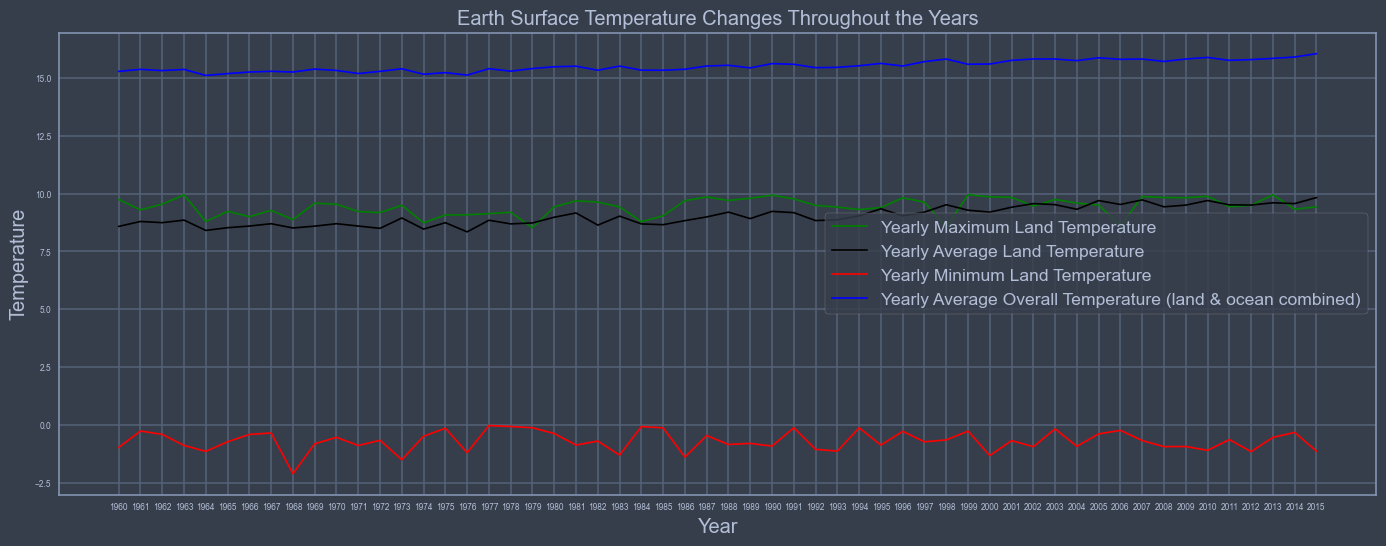

In [25]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = floortemp_relevant_years.toPandas()

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = floortemp_relevant_years.toPandas()

# Convert temperature columns to numeric type
pandas_df['YearlyLandMinTemperature'] = pd.to_numeric(pandas_df['YearlyLandMinTemperature'], errors='coerce')
pandas_df['YearlyLandMaxTemperature'] = pd.to_numeric(pandas_df['YearlyLandMaxTemperature'], errors='coerce')

# Plotting
plt.figure(figsize=(17, 6))

# Line plot for YearlyLandMaxTemperature (green)
plt.plot(pandas_df['Year'], pandas_df['YearlyLandMaxTemperature'], label='Yearly Maximum Land Temperature', color='green')

# Line plot for YearlyLandAverageTemperature (brown)
plt.plot(pandas_df['Year'], pandas_df['YearlyLandAverageTemperature'], label='Yearly Average Land Temperature', color='black')

# Line plot for YearlyLandMinTemperature (red)
plt.plot(pandas_df['Year'], pandas_df['YearlyLandMinTemperature'], label='Yearly Minimum Land Temperature', color='red')

# Line plot for YearlyLandAndOceanAverageTemperature (blue)
plt.plot(pandas_df['Year'], pandas_df['YearlyLandAndOceanAverageTemperature'], label='Yearly Average Overall Temperature (land & ocean combined)', color='blue')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Earth Surface Temperature Changes Throughout the Years')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

# Adding legend
plt.legend()

# Show the plot
plt.show()

**to my surprise the average temperatures on earth each year remain roughly the same**

## crop yield index

**now let's look at our crop data**

In [16]:
# Define a checkbox widget
countries_only = widgets.Checkbox(
    value=False,
    description='Actual Countries Only'
)

display(countries_only)

Checkbox(value=False, description='Actual Countries Only')

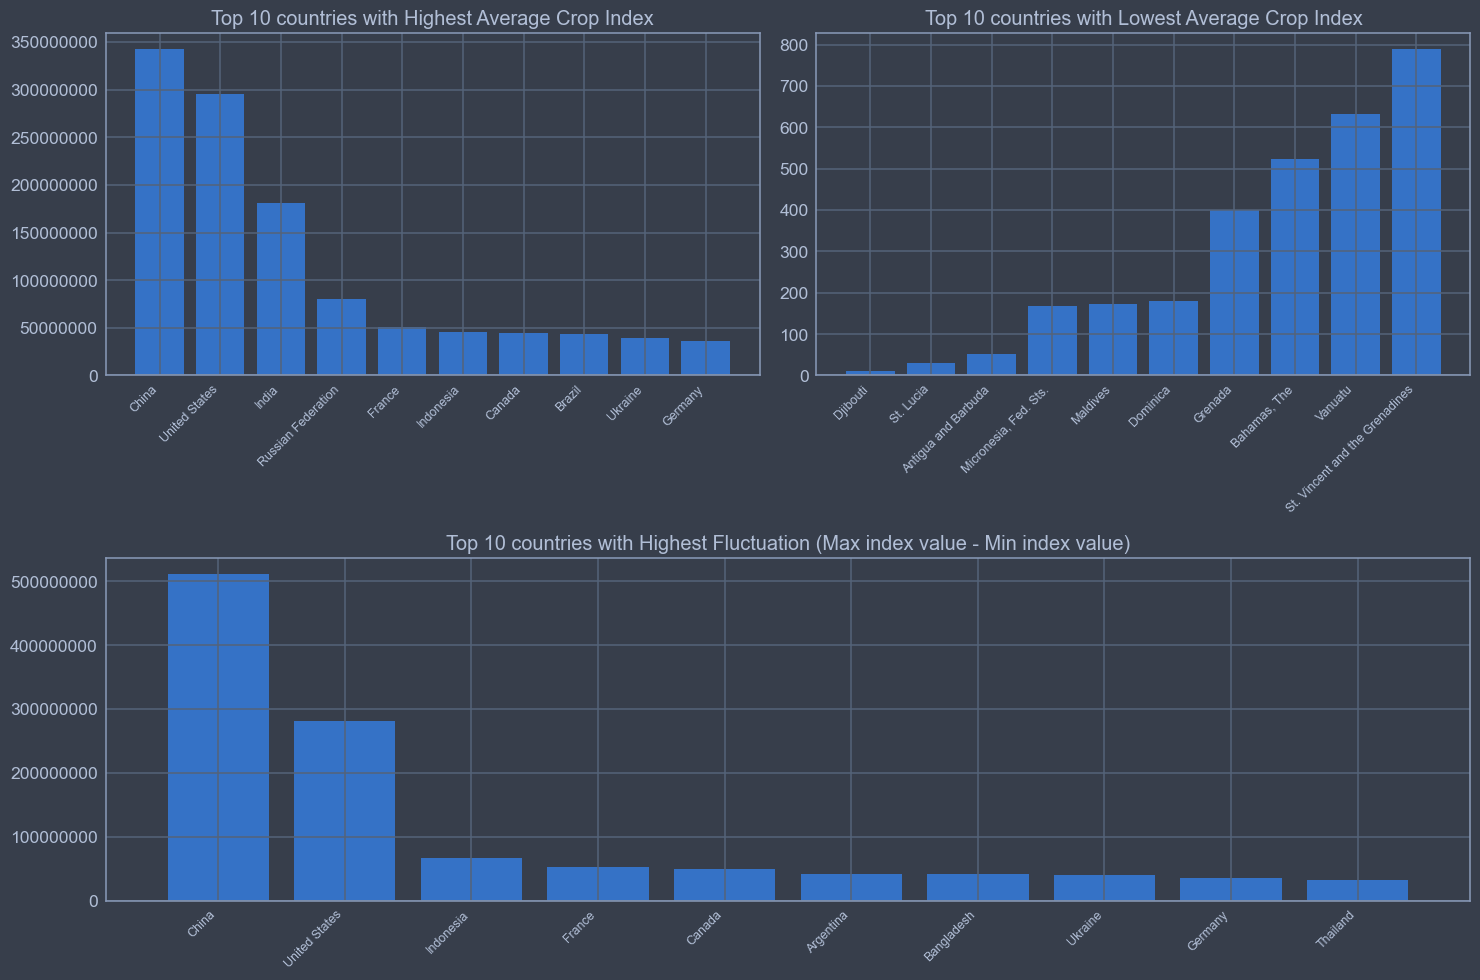

In [57]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_country_range_df = country_range_data.toPandas()

# Convert relevant columns to numeric
pandas_country_range_df['minVal'] = pd.to_numeric(pandas_country_range_df['minVal'], errors='coerce')
pandas_country_range_df['avgVal'] = pd.to_numeric(pandas_country_range_df['avgVal'], errors='coerce')
pandas_country_range_df['maxVal'] = pd.to_numeric(pandas_country_range_df['maxVal'], errors='coerce')

if countries_only.value == True:
    items_to_exclude = [
        "Africa Eastern and Southern",
        "Africa Western and Central",
        "Arab World",
        "Central Europe and the Baltics",
        "Early-demographic dividend",
        "East Asia & Pacific",
        "East Asia & Pacific (IDA & IBRD countries)",
        "East Asia & Pacific (excluding high income)",
        "Euro area",
        "Europe & Central Asia",
        "Europe & Central Asia (IDA & IBRD countries)",
        "Europe & Central Asia (excluding high income)",
        "European Union",
        "Fragile and conflict affected situations",
        "Heavily indebted poor countries (HIPC)",
        "High income",
        "IBRD only",
        "IDA & IBRD total",
        "IDA blend",
        "IDA only",
        "IDA total",
        "Late-demographic dividend",
        "Latin America & Caribbean",
        "Latin America & Caribbean (excluding high income)",
        "Latin America & the Caribbean (IDA & IBRD countries)",
        "Least developed countries: UN classification",
        "Low & middle income",
        "Low income",
        "Lower middle income",
        "Middle East & North Africa",
        "Middle East & North Africa (IDA & IBRD countries)",
        "Middle East & North Africa (excluding high income)",
        "Middle income",
        "North America",
        "OECD members",
        "Other small states",
        "Post-demographic dividend",
        "Pre-demographic dividend",
        "South Asia",
        "South Asia (IDA & IBRD)",
        "Sub-Saharan Africa",
        "Sub-Saharan Africa (IDA & IBRD countries)",
        "Sub-Saharan Africa (excluding high income)",
        "Upper middle income",
        "West Bank and Gaza",
        "World"
    ]
    # Exclude items from the DataFrame
    pandas_country_range_df = pandas_country_range_df[~pandas_country_range_df['CountryName'].isin(items_to_exclude)]

# Create a new column for fluctuation
pandas_country_range_df['fluctuation'] = pandas_country_range_df['maxVal'] - pandas_country_range_df['minVal']

# Sort the DataFrame by average crop index in descending order
sorted_avg_df = pandas_country_range_df.sort_values(by='avgVal', ascending=False)

# Get the top 10 countries with the highest average crop index
top_10_avg = sorted_avg_df.head(10)

# Sort the DataFrame by average crop index in ascending order
sorted_low_avg_df = pandas_country_range_df.sort_values(by='avgVal')

# Get the top 10 countries with the lowest average crop index
bottom_10_avg = sorted_low_avg_df.head(10)

# Sort the DataFrame by fluctuation in descending order
sorted_fluctuation_df = pandas_country_range_df.sort_values(by='fluctuation', ascending=False)

# Get the top 10 countries with the highest fluctuation
top_10_fluctuation = sorted_fluctuation_df.head(10)

# Plotting
plt.figure(figsize=(15, 10))

# Bar chart for the top 10 countries with the highest average crop index
plt.subplot(2, 2, 1)
plt.bar(top_10_avg['CountryName'], top_10_avg['avgVal'])
if countries_only.value == True:
    plt.title('Top 10 countries with Highest Average Crop Index')
else:
    plt.title('Top 10 places with Highest Average Crop Index')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ticklabel_format(style='plain', axis='y')

# Bar chart for the top 10 countries with the lowest average crop index
plt.subplot(2, 2, 2)
plt.bar(bottom_10_avg['CountryName'], bottom_10_avg['avgVal'])
if countries_only.value == True:
    plt.title('Top 10 countries with Lowest Average Crop Index')
else:
    plt.title('Top 10 places with Lowest Average Crop Index')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ticklabel_format(style='plain', axis='y')

# Bar chart for the top 10 countries with the highest fluctuation
plt.subplot(2, 1, 2)
plt.bar(top_10_fluctuation['CountryName'], top_10_fluctuation['fluctuation'])
if countries_only.value == True:
    plt.title('Top 10 countries with Highest Fluctuation (Max index value - Min index value)')
else:
    plt.title('Top 10 places with Highest Fluctuation (Max index value - Min index value)')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ticklabel_format(style='plain', axis='y')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**as you can seee the bigger countries have higher yields on average, which makes sense as they have more land to plant cereal on. You can also see that countries like China have the highest fluctuation, which is probably because they went through the biggest change throughout the 60's, industry-wise**

# data mixing

## data per country/place

In [18]:
w_country = widgets.Dropdown(
    options=countries_list,
    value='Afghanistan',
    description='Country: ',
    disabled=False,
)
display(w_country)

Dropdown(description='Country: ', options=('Afghanistan', 'Africa Eastern and Southern', 'Africa Western and C…

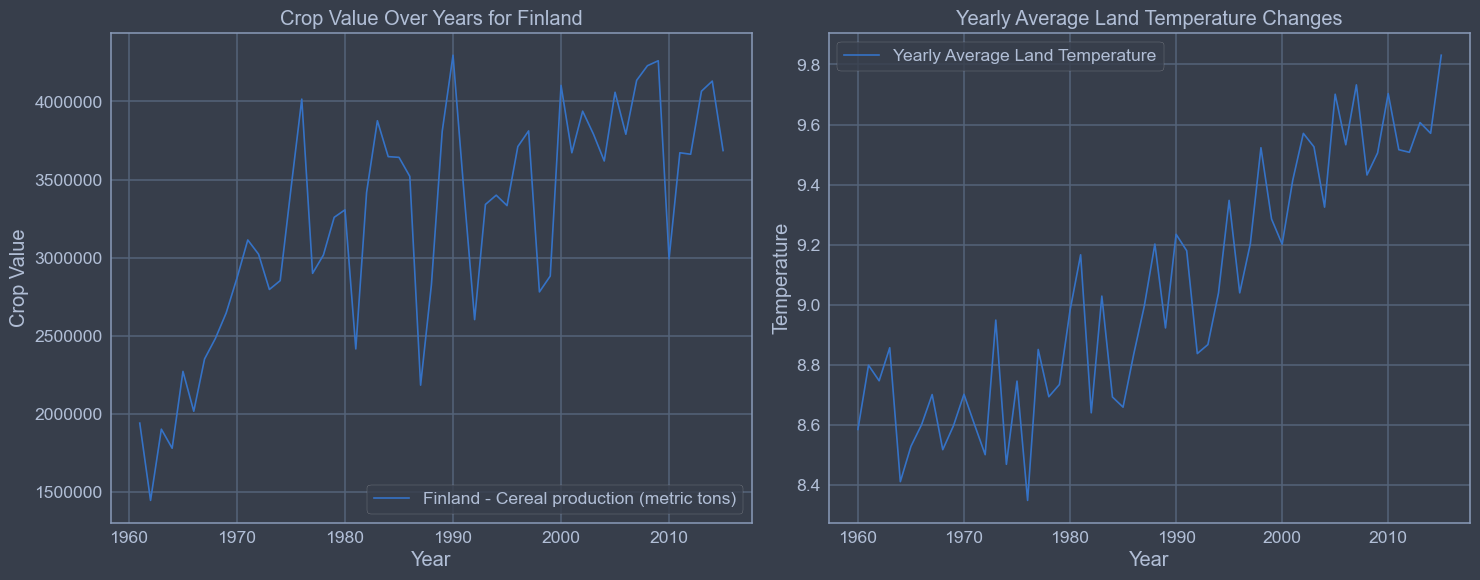

Average crop value for years with temperatures above the overall average: 97743984.56946503
Average crop value for years with temperatures below the overall average: 60545208.83700694
Global crop performance for Finland was better with higher land temperatures.


In [58]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_crop_df = cropdata_per_years.toPandas()

# Convert temperature columns to numeric type
pandas_crop_df['value'] = pd.to_numeric(pandas_crop_df['value'], errors='coerce')

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Assuming you want to plot the 'value' column for a specific 'CountryName'

# Filter data for the specified country
country_data = pandas_crop_df[pandas_crop_df['CountryName'] == w_country.value]

# Check if the DataFrame is not empty
if not country_data.empty:
    # Line plot for the 'value' column over the 'year' column
    ax1.plot(country_data['Year'], country_data['value'], label=f'{w_country.value} - {country_data["IndicatorName"].iloc[0]}')

    # Adding labels and title
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Crop Value')
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.set_title(f'Crop Value Over Years for {w_country.value}')
    ax1.legend()

    # Assuming you have pandas_df and overall_avg_temp available

    # Calculate global temperature deviation from overall average
    pandas_df['TempDeviation'] = pandas_df['YearlyLandAverageTemperature'] - overall_avg_temp

    # Line plot for YearlyLandAverageTemperature
    ax2.plot(pandas_df['Year'], pandas_df['YearlyLandAverageTemperature'], label='Yearly Average Land Temperature')

    # Adding labels and title
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Temperature')
    ax2.set_title('Yearly Average Land Temperature Changes')

    # Adding legend
    ax2.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
    
    pandas_df['Year'] = pandas_df['Year'].astype('int32')
    pandas_df['TempDeviation'] = pandas_df['YearlyLandAverageTemperature'] - overall_avg_temp

    # Define a threshold for considering higher and lower temperatures
    threshold = 0  # You can adjust this threshold as needed

    # Create a new column indicating whether the temperature is above or below the threshold
    pandas_df['TempCategory'] = np.where(pandas_df['TempDeviation'] > threshold, 'AboveAvg', 'BelowAvg')

    # Merge crop data with global temperature data on the 'Year' column
    merged_data = pd.merge(pandas_crop_df, pandas_df[['Year', 'TempCategory']], on='Year', how='left')

    # Check if the merged DataFrame is not empty
    if not merged_data.empty:
        # Group by temperature category and calculate the average crop value
        avg_crop_by_temp = merged_data.groupby('TempCategory')['value'].mean()

        # Print the results
        print(f"Average crop value for years with temperatures above the overall average: {avg_crop_by_temp['AboveAvg']}")
        print(f"Average crop value for years with temperatures below the overall average: {avg_crop_by_temp['BelowAvg']}")

        # Determine which category has a higher average crop value
        if avg_crop_by_temp['AboveAvg'] > avg_crop_by_temp['BelowAvg']:
            print(f"Global crop performance for {w_country.value} was better with higher land temperatures.")
        elif avg_crop_by_temp['AboveAvg'] < avg_crop_by_temp['BelowAvg']:
            print(f"Global crop performance for {w_country.value} was better with lower land temperatures.")
        else:
            print("There is no significant difference in global crop performance between higher and lower land temperatures.")
    else:
        print("No data available for the specified country.")
else:
    print(f"No data available for {w_country.value}.")
    


**vanuit deze data lijkt het alsof de meeste landen betere crop yields hadden bij hogere land temperaturen, maar je moet altijd skeptisch blijven (deze correlatie kan teoval zijn omdat de temperatuur van de aarde duidelijk stijgend is, en de meeste landen de voorbije 70 jaar een verbeterde industrie hebben gehad, wat meestal ook zal leiden tot een grotere graanproductie)**

## geographical data

In [21]:
w_year = widgets.Dropdown(
    options=years_list,
    value=1961,
    description='Year: ',
    disabled=False
)
display(w_year)

Dropdown(description='Year: ', options=(1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972…

In [22]:
# modifying crops_relevant_years with min, avg and max value data for use in folium map
sql = """
    SELECT 
        cry.*,
        crd.minVal,
        crd.avgVal,
        crd.maxVal
    FROM crops_relevant_years cry
    JOIN country_range_data crd
    ON cry.`Country Name` = crd.CountryName
    AND cry.`Country Code` = crd.CountryCode
    AND cry.`Indicator Name` = crd.IndicatorName
    AND cry.`Indicator Code` = crd.IndicatorCode
"""

df_crops_relevant_years = spark.sql(sql)
df_crops_relevant_years.createOrReplaceTempView('crops_relevant_years')

+--------------------+------------+--------------------+--------------+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----+--------+--------+--------+
|        Country Name|Country Code|      Indicator Name|Indicator Code|1960|    1961|    1962|    1963|    1964|    1965|    1966|    1967|    1968|    1969|    1970|    1971|    1972|    1973|    1974|    1975|    1976|    1977|    1978|    1979|    1980|    1981|    1982|    1983|    1984|    1985|    1986|    1987|  

**the main problem is that, because of the size of the data, the loading of the value, average, min, and max takes insanely long (more than a minute per country). Therefore the full map takes aroud 3-3.5 hours to load. Therefore i will load 5 random countries to show you how it works**

In [ ]:
from folium import features

#datapunten waarvoor ik niet genoeg context heb om accurate geografische data te plotten (zoals 'west-oost afrika', of 'laag inkomen') heb ik laten vallen voor deze visualisatie (lijst onder mapping dictionary)
geo_country_mapping = {
	"Afghanistan":"Afghanistan",
	"Albania":"Albania",
	"Algeria":"Algeria",
	"Angola":"Angola",
	"Argentina":"Argentina",
	"Armenia":"Armenia",
	"Australia":"Australia",
	"Austria":"Austria",
	"Azerbaijan":"Azerbaijan",
	"The Bahamas":"Bahamas, The",
	"Bangladesh":"Bangladesh",
	"Belarus":"Belarus",
	"Belgium":"Belgium",
	"Belize":"Belize",
	"Benin":"Benin",
	"Bhutan":"Bhutan",
	"Bolivia":"Bolivia",
	"Bosnia and Herzegovina":"Bosnia and Herzegovina",
	"Botswana":"Botswana",
	"Brazil":"Brazil",
	"Brunei":"Brunei Darussalam",
	"Bulgaria":"Bulgaria",
	"Burkina Faso":"Burkina Faso",
	"Burundi":"Burundi",
	"Cambodia":"Cambodia",
	"Cameroon":"Cameroon",
	"Canada":"Canada",
	"Central African Republic":"Central African Republic",
	"Chad":"Chad",
	"Chile":"Chile",
	"China":"China",
	"Colombia":"Colombia",
	"Democratic Republic of the Congo":"Congo, Dem. Rep.",
	"Republic of the Congo":"Congo, Rep.",
	"Costa Rica":"Costa Rica",
	"Ivory Coast":"Cote d'Ivoire",
	"Croatia":"Croatia",
	"Cuba":"Cuba",
	"Cyprus":"Cyprus",
	"Czech Republic":"Czechia",
	"Denmark":"Denmark",
	"Djibouti":"Djibouti",
	"Dominican Republic":"Dominican Republic",
	"Ecuador":"Ecuador",
	"Egypt":"Egypt, Arab Rep.",
	"El Salvador":"El Salvador",
	"Eritrea":"Eritrea",
	"Estonia":"Estonia",
	"Ethiopia":"Ethiopia",
	"Fiji":"Fiji",
	"Finland":"Finland",
	"France":"France",
	"Gabon":"Gabon",
	"Gambia":"Gambia, The",
	"Georgia":"Georgia",
	"Germany":"Germany",
	"Ghana":"Ghana",
	"Greece":"Greece",
	"Guatemala":"Guatemala",
	"Guinea":"Guinea",
	"Guinea Bissau":"Guinea-Bissau",
	"Guyana":"Guyana",
	"Haiti":"Haiti",
	"Honduras":"Honduras",
	"Hungary":"Hungary",
	"Iceland":"Iceland",
	"India":"India",
	"Indonesia":"Indonesia",
	"Iran":"Iran, Islamic Rep.",
	"Iraq":"Iraq",
	"Ireland":"Ireland",
	"Israel":"Israel",
	"Italy":"Italy",
	"Jamaica":"Jamaica",
	"Japan":"Japan",
	"Jordan":"Jordan",
	"Kazakhstan":"Kazakhstan",
	"Kenya":"Kenya",
	"North Korea":"Korea, Dem. People's Rep.",
	"South Korea":"Korea, Rep.",
	"Kuwait":"Kuwait",
	"Kyrgyzstan":"kyrg Republic",
	"Laos":"Lao PDR",
	"Latvia":"Latvia",
	"Lebanon":"Lebanon",
	"Lesotho":"Lesotho",
	"Liberia":"Liberia",
	"Libya":"Libya",
	"Lithuania":"Lithuania",
	"Luxembourg":"Luxembourg",
	"Madagascar":"Madagascar",
	"Malawi":"Malawi",
	"Malaysia":"Malaysia",
	"Mali":"Mali",
	"Mauritania":"Mauritania",
	"Mexico":"Mexico",
	"Moldova":"Moldova",
	"Mongolia":"Mongolia",
	"Montenegro":"Montenegro",
	"Morocco":"Morocco",
	"Mozambique":"Mozambique",
	"Myanmar":"Myanmar",
	"Namibia":"Namibia",
	"Nepal":"Nepal",
	"Netherlands":"Netherlands",
	"New Caledonia":"New Caledonia",
	"New Zealand":"New Zealand",
	"Nicaragua":"Nicaragua",
	"Niger":"Niger",
	"Nigeria":"Nigeria",
	"Macedonia":"North Macedonia",
	"Norway":"Norway",
	"Oman":"Oman",
	"Pakistan":"Pakistan",
	"Panama":"Panama",
	"Papua New Guinea":"Papua New Guinea",
	"Paraguay":"Paraguay",
	"Peru":"Peru",
	"Philippines":"Philippines",
	"Poland":"Poland",
	"Portugal":"Portugal",
	"Puerto Rico":"Puerto Rico",
	"Qatar":"Qatar",
	"Romania":"Romania",
	"Russia":"Russian Federation",
	"Rwanda":"Rwanda",
	"Saudi Arabia":"Saudi Arabia",
	"Senegal":"Senegal",
	"Republic of Serbia":"Serbia",
	"Sierra Leone":"Sierra Leone",
	"Slovakia":"Slovak Republic",
	"Slovenia":"Slovenia",
	"Solomon Islands":"Solomon Islands",
	"Somalia":"Somalia",
	"South Africa":"South Africa",
	"South Sudan":"South Sudan",
	"Spain":"Spain",
	"Sri Lanka":"Sri Lanka",
	"Sudan":"Sudan",
	"Suriname":"Suriname",
	"Sweden":"Sweden",
	"Switzerland":"Switzerland",
	"Syria":"Syrian Arab Republic",
	"Tajikistan":"Tajikistan",
	"United Republic of Tanzania":"Tanzania",
	"Thailand":"Thailand",
	"East Timor":"Timor-Leste",
	"Togo":"Togo",
	"Trinidad and Tobago":"Trinidad and Tobago",
	"Tunisia":"Tunisia",
	"Turkey":"Turkiye",
	"Turkmenistan":"Turkmenistan",
	"Uganda":"Uganda",
	"Ukraine":"Ukraine",
	"United Arab Emirates":"United Arab Emirates",
	"United Kingdom":"United Kingdom",
	"United States of America":"United States",
	"Uruguay":"Uruguay",
	"Uzbekistan":"Uzbekistan",
	"Vanuatu":"Vanuatu",
	"Venezuela":"Venezuela, RB",
	"Vietnam":"Viet Nam",
	"Yemen":"Yemen, Rep.",
	"Zambia":"Zambia",
	"Zimbabwe":"Zimbabwe",
}

#countries/datapoints i left out:

#"Africa Eastern and Southern":[], niet genoeg context (22 landen maar zegt niet welke)
#"Africa Western and Central":[], niet genoeg context (26 landen maar zegt niet welke)
#"Antigua and Barbuda":[], is deel van carribian
#"Arab World":[], niet genoeg context
#"Barbados":[], is deel van carribian
#"Cabo Verde":[], niet aanwezig in deze geojson //
#"Caribbean small states":[], niet aanwezig in deze geojson //
#"Central Europe and the Baltics":[], meeste baltische landen zijn al aanwezig aanzich
#"Comoros":[], niet aanwezig in deze geojson //
#"Dominica":[], deel van carribian
#"Early-demographic dividend":[], niet genoeg context
#"East Asia & Pacific":[], niet genoeg context
#"East Asia & Pacific (IDA & IBRD countries)":[], niet genoeg context
#"East Asia & Pacific (excluding high income)":[], niet genoeg context
#"Eswatini":[], niet in deze geojson //
#"Euro area":[], euro landen al individueel aanwezig
#"Europe & Central Asia":[], niet genoeg context
#"Europe & Central Asia (IDA & IBRD countries)":[], niet genoeg context
#"Europe & Central Asia (excluding high income)":[], niet genoeg context
#"European Union":[], landen al individueel aanwezig
#"Fragile and conflict affected situations":[], niet genoeg context en irrelevant
#"Grenada":[], deel van carribian
#"Heavily indebted poor countries (HIPC)":[], niet genoeg context en irrelevant
#"High income":[], niet genoeg context en irrelevant
#"Hong Kong SAR, China":[], niet aanwezig in deze geojson //
#"IBRD only":[], niet genoeg context en irrelevant
#"IDA & IBRD total":[], niet genoeg context en irrelevant
#"IDA blend":[], niet genoeg context en irrelevant
#"IDA only":[], niet genoeg context en irrelevant
#"IDA total":[], niet genoeg context en irrelevant
#"Late-demographic dividend":[], niet genoeg context en irrelevant
#"Latin America & Caribbean":[], landen al individueel aanwezig of geen deel van geojson //
#"Latin America & Caribbean (excluding high income)":[], landen al individueel aanwezig of geen deel van geojson
#"Latin America & the Caribbean (IDA & IBRD countries)":[], landen al individueel aanwezig of geen deel van geojson
#"Least developed countries: UN classification":[], niet genoeg context en irrelevant
#"Low & middle income":[], niet genoeg context en irrelevant
#"Low income":[], niet genoeg context en irrelevant
#"Lower middle income":[], niet genoeg context en irrelevant
#"Maldives":[], niet aanwezig in deze geojson //
#"Malta":[], niet aanwezig in deze geojson //
#"Mauritius":[], niet aanwezig in deze geojson //
#"Micronesia, Fed. Sts.":[], niet aanwezig in deze geojson //
#"Middle East & North Africa":[], niet genoeg context en landen al aanwezig aanzich
#"Middle East & North Africa (IDA & IBRD countries)":[], niet genoeg context en landen al aanwezig aanzich
#"Middle East & North Africa (excluding high income)":[], niet genoeg context en landen al aanwezig aanzich
#"Middle income":[], niet genoeg context en irrelevant
#"North America":[], landen individueel al aanwezig
#"OECD members":[], niet genoeg context en irrelevant
#"Other small states":[], niet genoeg context
#"Pacific island small states":[], niet genoeg context
#"Post-demographic dividend":[], niet genoeg context en irrelevant
#"Pre-demographic dividend":[], niet genoeg context en irrelevant
#"Sao Tome and Principe":[], niet aanwezig in deze geojson //
#"South Asia":[], zuid aziatische landen al individueel aanwezig
#"South Asia (IDA & IBRD)":[], context en irrelevant
#"St. Lucia":[], deel van carribian
#"St. Vincent and the Grenadines":[], deel van carribian
#"Sub-Saharan Africa":[], landen al individueel aanwezig
#"Sub-Saharan Africa (IDA & IBRD countries)":[], context en irrelevant
#"Sub-Saharan Africa (excluding high income)":[], context en irrelevant
#"Upper middle income":[], context en irrelevant
#"West Bank and Gaza":[], deel van israel
#"World":[], irrelevant voor deze kaart

geo_country_mapping = {
    "El Salvador":"El Salvador",
	"Eritrea":"Eritrea",
	"Estonia":"Estonia",
	"Ethiopia":"Ethiopia",
	"United States of America":"United States"
}


# Create a base map
m = folium.Map(location=[0, 0], zoom_start=2)

# data maar 1 keer inladen
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
geojson_data = requests.get(geojson_url).json()

# Add country boundaries using GeoJSON
folium.GeoJson(
    geojson_data,
    name='geojson'
).add_to(m)
    
    
# Instead of filtering the DataFrame for each country inside the loop, filter it once and store the results in a dictionary for quick lookup.
# Assuming cropdata_per_years is a DataFrame
country_data_dict = {}
for country_name in geo_country_mapping.keys():
    country_data = cropdata_per_years.filter(
        (cropdata_per_years['CountryName'] == geo_country_mapping[country_name]) &
        (cropdata_per_years['Year'] == w_year.value)
    ).collect()

    if country_data:
        country_data_dict[country_name] = country_data[0]

def style_function(feature):
    country_name = feature['properties']['name']
    
    # Check if the country is in the mapping
    if country_name in geo_country_mapping.keys():
        # Filter the DataFrame for the specific country
        country_data = cropdata_per_years.filter((cropdata_per_years['CountryName'] == geo_country_mapping[country_name]) & (cropdata_per_years['Year'] == w_year.value)).collect()
        range_data = country_range_data.filter(country_range_data['CountryName'] == geo_country_mapping[country_name]).collect()
        print(country_name)
        print(geo_country_mapping[country_name])
        print(country_data)
        print(range_data)
        
        # Check if the country has data
        if country_data:
            try:
                print(f"trying colormap for {country_name}")
                min_val = float(range_data[0]['minVal'])
                avg_val = float(range_data[0]['avgVal'])
                max_val = float(range_data[0]['maxVal'])
                value = float(country_data[0]['value'])
                
                # Create a LinearColormap based on min and max values for the specific country
                color_map = branca.colormap.LinearColormap(["red", "orange", "lime"], [min_val, avg_val, max_val], vmin=min_val, vmax=max_val)

                # Adjust the color based on the 'avgVal' value
                print("colormap applied")
                return {
                    'fillColor': color_map(value),
                    'fillOpacity': 0.8,
                    'weight': 0.8,
                    'color': color_map(value)
                }
            except:
                print("colormap failed")
                return {'fillColor': 'grey', 'color': 'grey'}
        else:
            return {'fillColor': 'grey', 'color': 'grey'}
        
    # Default color for countries not in the mapping or missing data
    else:
        return {'fillColor': 'grey', 'color': 'grey'}

    
    
# Add the GeoJSON layer with styling
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=style_function
).add_to(m)

# Add a gradient legend
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 200px; 
                 border:2px solid grey; z-index:9999; font-size:12px;
                 background-color: white;
                 ">
     <p style="text-align:center; font-weight: bold;">Yield Index Legend</p>
     <p style="text-align:center; color: red;">Below Average</p>
     <p style="text-align:center; color: orange;">Average</p>
     <p style="text-align:center; color: lime;">Above Average</p>
     </div>
     """
m.get_root().html.add_child(folium.Element(legend_html))

# Show the map
m

Eritrea
Eritrea
[Row(Year=2009, CountryName='Eritrea', CountryCode='ERI', IndicatorName='Cereal production (metric tons)', IndicatorCode='AG.PRD.CREL.MT', value='226899', _c67=None)]
[Row(CountryName='Eritrea', CountryCode='ERI', IndicatorName='Cereal production (metric tons)', IndicatorCode='AG.PRD.CREL.MT', minVal=105788, avgVal=230459, maxVal=99380)]
trying colormap for Eritrea
colormap applied
Estonia
Estonia
[Row(Year=2009, CountryName='Estonia', CountryCode='EST', IndicatorName='Cereal production (metric tons)', IndicatorCode='AG.PRD.CREL.MT', value='873466', _c67=None)]
[Row(CountryName='Estonia', CountryCode='EST', IndicatorName='Cereal production (metric tons)', IndicatorCode='AG.PRD.CREL.MT', minVal=1221600, avgVal=739733, maxVal=991200)]
trying colormap for Estonia
colormap applied
Ethiopia
Ethiopia
[Row(Year=2009, CountryName='Ethiopia', CountryCode='ETH', IndicatorName='Cereal production (metric tons)', IndicatorCode='AG.PRD.CREL.MT', value='16457164.46', _c67=None)]
[Row(

# Conclusion

The biggest takeaway it take from this exercise is that it is pretty hard to work with large datasets as it tanks performance. Apart from that this was a good learning experience and i feel like i could plot something useful (even if it takes several hours to fully run).I also found it quite enjoyable and it shows how even tho you might see a correlation, that doesn't mean one is the cause of the other (like how in my data industrial improvement probably greatly overshadows any effect land temperature might have had.